# Benjamin Lavoie (benjaminlavoie02@gmail.com)

# CapStone project: Gaming Score Forecasting Model

# Last update: March 15th, 2024 (version 2.1)

# Notebook 2: Pre-processing and Processing

# Table of Contents

**[3. Part 3 - Introduction (2nd Notebook)](#heading--3)**

  * [3.1 - Data Dictionary](#heading--3-1)

  * [3.2 - Separating the dataframe](#heading--3-2)

  * [3.3 - One hot encoding (dummy variables)](#heading--3-3)
  
  * [3.4 - Columns to vectorize with TFDIF](#heading--3-4)
    
  * [3.5 - Variance Threshold](#heading--3-5)
  

**[4. Part 4 - Modeling](#heading--4)**
  
  * [4.1 - First Scores, some optimization](#heading--4-1)
  
  * [4.2 - Confusion Matrix](#heading--4-2)
  

In [141]:

# Necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
import statsmodels.api as sm
import glob
import os
from scipy.stats import chi2_contingency


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To plot
from scipy import stats
from scipy.stats import norm 

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To process text data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold



#imporint different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# To see more columns at once, I'll change the display.max_columns number
pd.set_option('display.max_columns', 50)

<div id="heading--3"/>

## 3. Part 3 - Introduction (2nd Notebook)

The cleaning and the EDA has all been done in the 1st Notebook.

In this 2nd Notebook, I will be doing the pre-processing as well as the processing/modeling.

I will start importing the data set, and then by separating the dataset. Since I have 14k+ rows and not 100k+ rows, I'll keep only 20% for the testing.

<div id="heading--3-1"/>

## 3.1 - Data Dictionary:

| Feature/Column | Definition | Data type |
|----------|----------|----------|
| Platform | Platform the game was released on | String |
| Developer | Developer of the game | String |
| Publisher | Publisher of the game | String |
| Genre | Genre of the game | String |
| Platform_Brand | Brand of the platform (Nintendo, Sony, Microsoft, PC | String |
| Platform_Type | Type of the platform (HomeConsole, Handheld, PC) | String |
| Release Date | Release date | DateTime |
| Metascore_Range | Classification: Weak, Okay or Strong | String |

In [142]:
df = pd.read_csv('clean_data_2.0.csv', index_col='Unnamed: 0', header=0)

In [143]:
df.head(5)

,Name,Platform,Publisher,Developer,Genre,Platform_Brand,Platform_Type,Release_Date,Release_Day,Release_Month,Release_Year,Metascore_Range
0,Wii Sports,Wii,Nintendo,Nintendo EAD,Sports,Nintendo,HomeConsole,2006-11-19,19,11,2006,Okay
1,Mario Kart 8 Deluxe,NS,Nintendo,Nintendo EPD,Racing,Nintendo,HomeConsole,2017-04-28,28,4,2017,Strong
2,Team Fortress 2,PC,Valve,Valve Corporation,Shooter,PC,PC,2007-10-10,10,10,2007,Strong
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2012-08-21,21,8,2012,Strong
4,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2015-10-23,23,10,2015,Strong


<div id="heading--3-2"/>

## 3.2 - Separating the dataframe

Let's separate the data in train and test sets.

In [144]:
df.drop(['Platform', 'Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)
# df.drop(['Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)

In [145]:
# separating into X and y

X = df.drop(columns="Metascore_Range")
y = df["Metascore_Range"]


# Separating into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# resetting the indexes to be able to separate the review columns and concatenate them easily later
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 12221 data points.
The TEST set has 2157 data points.


In [99]:
# might use later

# for col1 in X_train.columns:
#     for col2 in X_train.columns:
#         if col1 != col2:
#             contingency_table = pd.crosstab(X_train[col1], X_train[col2])
#             chi2, p, _, _ = chi2_contingency(contingency_table)
#             if (p > 1e-10):
#                 print(f'Chi-square test between {col1} and {col2}: Chi2={chi2}, p-value={p}')

<div id="heading--3-3"/>

## 3.3 - One hot encoding (dummy variables)

<br>

I will transform some of the columns into dummy variables
- Platform (testing with and without)
- Genre
- Platform_Brand
- Platform_Type

In [146]:
# when trying without platform

# X_train_numerical = X_train[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

# X_test_numerical = X_test[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

# X_train = pd.concat([X_train, X_train_dummy], axis="columns")
# X_test = pd.concat([X_test, X_test_dummy], axis="columns")

# X_train.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
# X_test.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)




X_train_numerical = X_train[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

X_test_numerical = X_test[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

X_train = pd.concat([X_train, X_train_dummy], axis="columns")
X_test = pd.concat([X_test, X_test_dummy], axis="columns")


X_train.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
X_test.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)


In [147]:
# sanity check with all the dfs

print(X_train_numerical.shape)
print(X_train_dummy.shape)
print(X_test_numerical.shape)
print(X_test_dummy.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

(12221, 3)
(12221, 26)
(2157, 3)
(2157, 26)
(12221, 29)
(2157, 29)
0
0


In [148]:
# checking the columns

X_train.columns

Index(['Name', 'Publisher', 'Developer', 'Genre_Action',
       'Genre_Action-Adventure', 'Genre_Adventure', 'Genre_Board Game',
       'Genre_Fighting', 'Genre_MMO', 'Genre_Misc', 'Genre_Music',
       'Genre_Party', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Sandbox', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Genre_Visual Novel', 'Platform_Brand_Microsoft',
       'Platform_Brand_Nintendo', 'Platform_Brand_PC', 'Platform_Brand_Sony',
       'Platform_Type_Handheld', 'Platform_Type_HomeConsole',
       'Platform_Type_PC'],
      dtype='object')

I think that using a NLP is a good idea, so I will use TF IDF to create more features. Then, I will be able to continue the processing.

<div id="heading--3-4"/>

## 3.4 - Columns to vectorize with TFDIF

Before vectorizing, I will create a my_tokenizer function to tokenize properly some columns

In [149]:
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

# Custom stopwords to be added

custom_stopwords = []
custom_stopwords = ['game', 'games', 'unknown', 'studio', 'inc', 'ltd', 'studios']

# Extend stopwords with custom stopwords
ENGLISH_STOP_WORDS.extend(custom_stopwords)

# my_tokenizer function, to be used when vectorizing
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

Now, I will vectorize 3 columns: Name, Publisher and Developer.

Under the code, I will also create histograms to show the 20 most weighted words in each column.

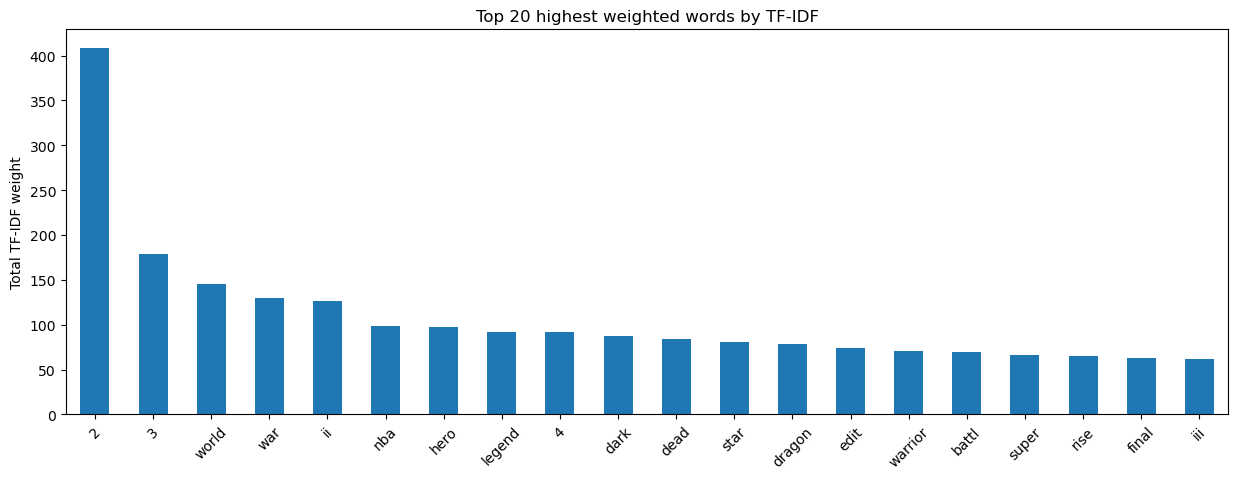

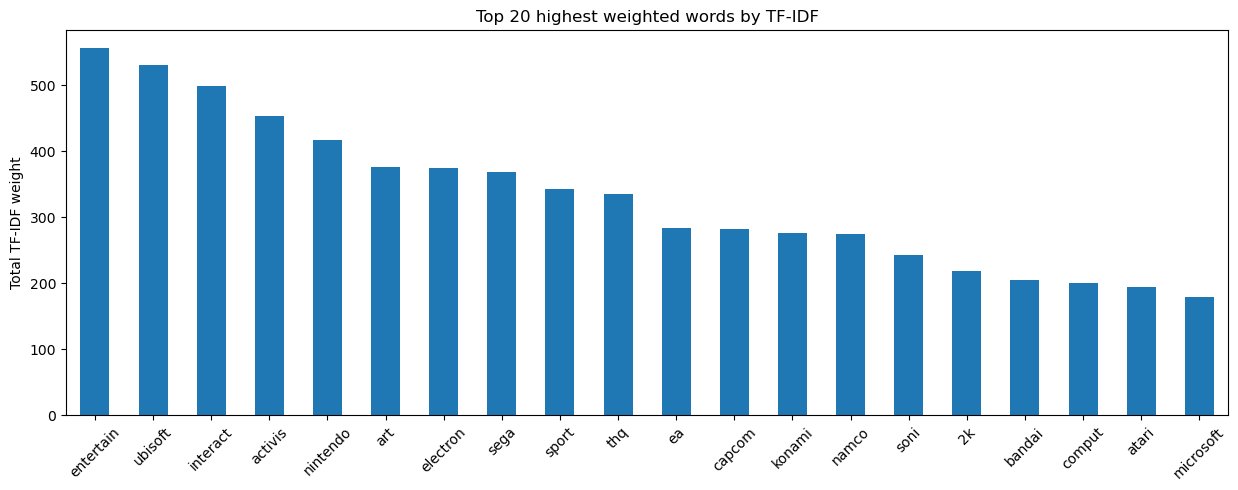

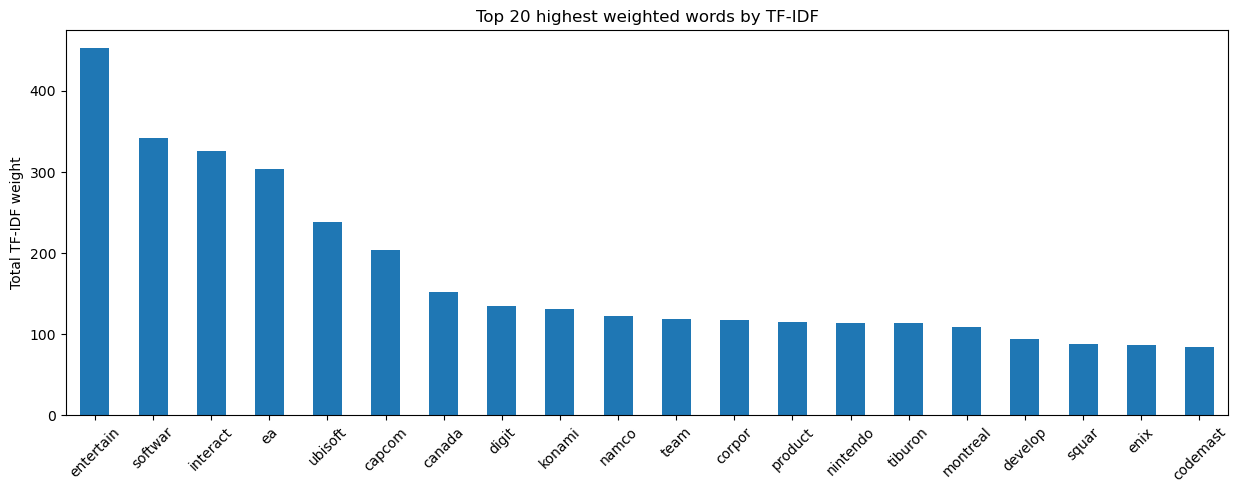

0
0
(12221, 1382)
(2157, 1382)


In [150]:
tfidf_columns = ['Name', 'Publisher', 'Developer']

tfidf_dfs = []
X_train_keep = pd.DataFrame()

for col in tfidf_columns:

    tfidf = TfidfVectorizer(tokenizer = my_tokenizer, min_df=10)

    # Fit and transform the text data
    transformed_train = tfidf.fit_transform(X_train[col])
    transformed_test = tfidf.transform(X_test[col])
    
    # store my vectorizers
    tfidf_dfs.append(tfidf)

    # Convert the transformed data into a dataframe
    tfidf_df_train = pd.DataFrame(transformed_train.toarray(),
                                   columns=tfidf.get_feature_names_out())

    tfidf_df_test = pd.DataFrame(transformed_test.toarray(),
                                   columns=tfidf.get_feature_names_out())


    # Join the 2 tfidf_df with the 2 dfs
    tfidf_df_train = tfidf_df_train.add_prefix(f'{col}_')
    tfidf_df_test = tfidf_df_test.add_prefix(f'{col}_')
    X_train = pd.concat([X_train, tfidf_df_train], axis="columns")
    X_test = pd.concat([X_test, tfidf_df_test], axis="columns")
    
    X_train_keep[col] = X_train[col]
    
    X_train.drop(col, axis = 1, inplace=True)
    X_test.drop(col, axis = 1, inplace=True)
    
    word_counts = pd.DataFrame(
        {"counts": transformed_train.toarray().sum(axis=0)},
        index=tfidf.get_feature_names_out()
    ).sort_values("counts", ascending=False)

    word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title("Top 20 highest weighted words by TF-IDF")
    plt.ylabel("Total TF-IDF weight")
    plt.xticks(rotation=45)
    plt.show()

# checking for null values and the shapes
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

In [151]:
# sanity check

X_train.head()

,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Board Game,Genre_Fighting,Genre_MMO,Genre_Misc,Genre_Music,Genre_Party,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel,Platform_Brand_Microsoft,Platform_Brand_Nintendo,Platform_Brand_PC,Platform_Brand_Sony,Platform_Type_Handheld,Platform_Type_HomeConsole,...,Developer_unlimit,Developer_valv,Developer_vancouv,Developer_vicari,Developer_viciou,Developer_view,Developer_viscer,Developer_vision,Developer_visual,Developer_volit,Developer_voltag,Developer_wale,Developer_ward,Developer_way,Developer_wayforward,Developer_white,Developer_wild,Developer_work,Developer_world,Developer_yacht,Developer_yuke,Developer_zaxi,Developer_zen,Developer_zenimax,Developer_zoink
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12221 entries, 0 to 12220
Columns: 1382 entries, Genre_Action to Developer_zoink
dtypes: float64(1356), int32(26)
memory usage: 127.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Columns: 1382 entries, Genre_Action to Developer_zoink
dtypes: float64(1356), int32(26)
memory usage: 22.5 MB
None


Before modeling, dropping one last column:

In [153]:
# dopping at the beginning, keeping this if needed

# X_train.drop('Release_Date', axis = 1, inplace=True)
# X_test.drop('Release_Date', axis = 1, inplace=True)


<div id="heading--3-5"/>

## 3.5 - Variance Threshold


With the variance threshold, I will only keep values that have a variance over the threshold. This way, all the columns that I don't need can be removed.

In [154]:
# setting the threshold

threshold_value = 0.001
selector = VarianceThreshold(threshold=threshold_value)

# Fit and transform the selector to X_train
X_selected = selector.fit_transform(X_train)

# Get the support mask
support_mask = selector.get_support()

# Get the indices of features to keep
indices_to_keep = [i for i, support in enumerate(support_mask) if support]

# Print the indices of features to keep
print("Indices of features to keep:", indices_to_keep)

X_train = X_train.iloc[:,indices_to_keep]
X_test = X_test.iloc[:,indices_to_keep]

Indices of features to keep: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 41, 43, 44, 45, 46, 65, 66, 67, 69, 77, 78, 79, 83, 85, 86, 97, 98, 101, 105, 106, 117, 118, 120, 121, 122, 123, 125, 127, 129, 130, 136, 137, 142, 145, 155, 164, 165, 166, 167, 173, 175, 177, 180, 182, 183, 185, 189, 190, 198, 202, 204, 206, 214, 216, 218, 220, 221, 224, 226, 236, 243, 246, 249, 251, 255, 258, 259, 260, 263, 265, 267, 269, 273, 277, 279, 285, 288, 289, 294, 299, 301, 303, 305, 308, 311, 312, 313, 315, 316, 322, 323, 333, 344, 345, 348, 353, 355, 357, 359, 363, 364, 369, 371, 372, 373, 376, 381, 393, 395, 396, 404, 405, 406, 408, 418, 419, 421, 428, 429, 431, 432, 434, 436, 437, 439, 440, 442, 443, 446, 447, 448, 450, 452, 458, 460, 462, 463, 467, 470, 471, 473, 484, 485, 487, 493, 502, 503, 504, 509, 512, 513, 514, 516, 520, 525, 526, 529, 531, 537, 539, 540, 544, 549, 550, 554, 558, 559, 561, 564, 565, 569, 571, 573, 574, 579, 583, 587, 591

In [155]:
# sanity check to confirm the number of columns

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12221 entries, 0 to 12220
Columns: 612 entries, Genre_Action to Developer_zaxi
dtypes: float64(588), int32(24)
memory usage: 55.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Columns: 612 entries, Genre_Action to Developer_zaxi
dtypes: float64(588), int32(24)
memory usage: 9.9 MB
None


Because I removed a lot of columns, it created duplicated rows. So I will check where they are and remove them in both the X and y, train and test dfs.

In [156]:
# checking the number of duplicated rows

print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

1713
170


In [157]:
# dropping the duplicated rows on all the dfs

# list of indices of the duplicated rows in X_train
duplicate_indices = X_train[X_train.duplicated()].index

# Remove duplicate rows from X_train
X_train = X_train.drop_duplicates()

# Remove corresponding rows from y_train
y_train = y_train.drop(index=duplicate_indices)


# list of indices of the duplicated rows in X_test
duplicate_indices = X_test[X_test.duplicated()].index

# Remove duplicate rows from X_test
X_test = X_test.drop_duplicates()

# Remove corresponding rows from y_test
y_test = y_test.drop(index=duplicate_indices)

<div id="heading--4"/>

## 4. Part 4 - Modeling

<br>

I will start the modeling with different models at first.

I will also store the test scores in the df_scores dataframe.

### This part is still under construction. Some cells are work in progress.

In [158]:
# instantiating df_scores to store scores

df_scores=pd.DataFrame(columns=['score'])

df_scores

,score


In [113]:
# Split the data into remainder and test sets
X_rem_logit, X_test_logit, y_rem_logit, y_test_logit = train_test_split(X_train, y_train, test_size=0.3, random_state=26, stratify=y_train)

# Split the remainder set into train and validation sets
X_train_logit, X_val_logit, y_train_logit, y_val_logit = train_test_split(X_rem_logit, y_rem_logit, test_size=0.2, random_state=96, stratify=y_rem_logit)

# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train_logit)} data points.')
print(f'The VALIDATION set has {len(X_val_logit)} data points.')
print(f'The TEST set has {len(X_test_logit)} data points.')

The TRAIN set has 5870 data points.
The VALIDATION set has 1468 data points.
The TEST set has 3146 data points.


In [114]:
%%time

# Baseline logistic regression

# Instantiate and fit to the train
baseline_logreg = LogisticRegression(max_iter = 5000, n_jobs=-1).fit(X_rem_logit, y_rem_logit)


# Print the accuracies
print(f'Accuracy on test set: {baseline_logreg.score(X_test_logit, y_test_logit)}')

df_scores.loc[f"Baseline log reg : C={baseline_logreg.get_params()['C']}"]=round(baseline_logreg.score(X_test_logit, y_test_logit),3)
df_scores

Accuracy on test set: 0.5247933884297521
CPU times: user 244 ms, sys: 387 ms, total: 632 ms
Wall time: 4.71 s


,score
Baseline log reg : C=1.0,0.525


In [115]:
%%time

# Let's try a modest range of C values
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg and fit to the train set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_train_logit, y_train_logit)

    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train_logit, y_train_logit))
    
    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_val_logit, y_val_logit))    

CPU times: user 32.7 s, sys: 5.54 s, total: 38.2 s
Wall time: 4.92 s


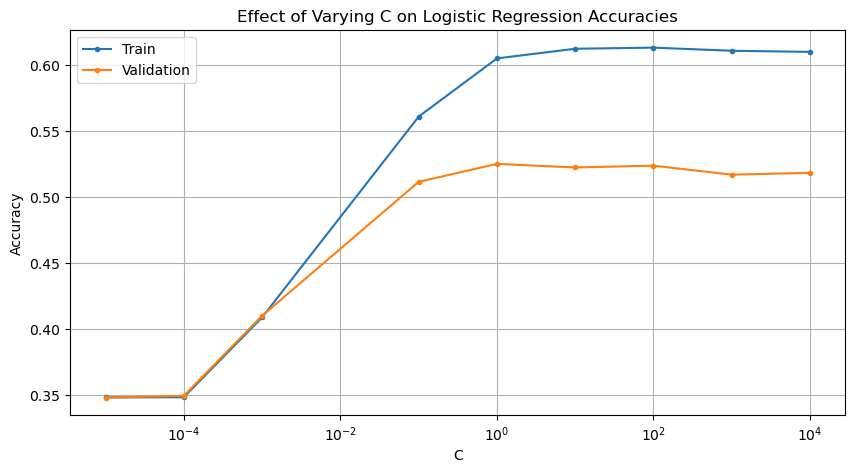

In [116]:
# Create a dataframe
scores_df=pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [117]:
best_c=c_values[np.argmax(validation_accuracies)]
best_c

1

In [118]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(C=best_c, random_state=1).fit(X_rem_logit, y_rem_logit)

# Print the test accuracy
print(f'Accuracy on test set: {validated_logreg.score(X_test_logit, y_test_logit)}')

Accuracy on test set: 0.5251112523839797


In [119]:
df_scores.loc[f"One-Fold : C={validated_logreg.get_params()['C']}"]=round(validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

,score
Baseline log reg : C=1.0,0.525
One-Fold : C=1,0.525


In [120]:
%%time

# This is the same range of C values that I used before
c_values = [.00001, .0001, .001, 0.01, .1, 1, 10, 100, 1000, 10000]

# Set up an empty list
cv_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg
    logreg = LogisticRegression(C=value, random_state=11, n_jobs=-1, max_iter=20000)

    # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
    cv_accuracy = np.mean(cross_val_score(logreg, X_rem_logit, y_rem_logit, cv=5, n_jobs=-1))

    # Append the cross-validated accuracy to the list set up above
    cv_accuracies.append(cv_accuracy)

    # Print something at the end of each iteration
    print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')

For a C value of 1e-05, the cross-validated accuracy is 0.348188
For a C value of 0.0001, the cross-validated accuracy is 0.34846
For a C value of 0.001, the cross-validated accuracy is 0.40679
For a C value of 0.01, the cross-validated accuracy is 0.44699
For a C value of 0.1, the cross-validated accuracy is 0.491822
For a C value of 1, the cross-validated accuracy is 0.502585
For a C value of 10, the cross-validated accuracy is 0.501224
For a C value of 100, the cross-validated accuracy is 0.500816
For a C value of 1000, the cross-validated accuracy is 0.500543
For a C value of 10000, the cross-validated accuracy is 0.500815
CPU times: user 707 ms, sys: 524 ms, total: 1.23 s
Wall time: 1min 25s


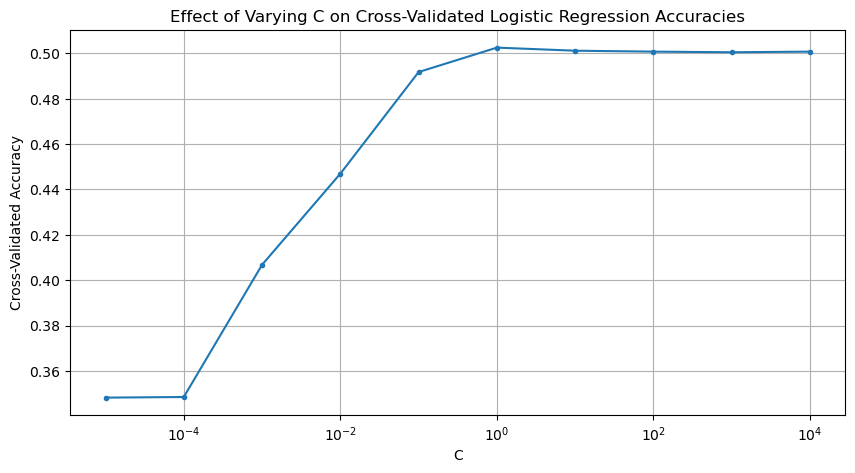

In [121]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, cv_accuracies, marker = '.')
plt.title('Effect of Varying C on Cross-Validated Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

In [122]:
# Instantiate a log reg and fit to the remainder set
cross_validated_logreg = LogisticRegression(C=1, random_state=11).fit(X_rem_logit, y_rem_logit)

# Print the accuracies
print(f'Accuracy on remainder set: {cross_validated_logreg.score(X_rem_logit, y_rem_logit)}')
print(f'Accuracy on test set: {cross_validated_logreg.score(X_test_logit, y_test_logit)}')

Accuracy on remainder set: 0.5651403652221314
Accuracy on test set: 0.5079465988556897


In [123]:
df_scores.loc[f"5-Fold : C={cross_validated_logreg.get_params()['C']}"]=round(cross_validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

,score
Baseline log reg : C=1.0,0.525
One-Fold : C=1,0.525
5-Fold : C=0.1,0.508


In [124]:
# Set up a directory to cache the pipeline results - if the same step with the same parameters is called again,
# the cached result is used instead of re-computing it.
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline(steps=[
                        ('scaler', StandardScaler()),
                        ('dim_reducer', PCA()),
                        ('model', LogisticRegression())],
                        memory=cachedir)

In [125]:
# testing the first pipeline

pipeline_test=my_pipeline.fit(X_train,y_train)
pipeline_test

Pipeline(memory='/var/folders/78/w0cjxhcs0bs0nxt9vj1kv61m0000gn/T/tmpw2b5np0d',
         steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()),
                ('model', LogisticRegression())])

In [126]:
# storing the pipeline_test score in the df_scores

pipeline_test.score(X_test,y_test)
df_scores.loc[f"pipeline_test: "]=round(baseline_logreg.score(X_test, y_test),3)

In [127]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)


In [128]:
# work in progress

# 1. Instantiate model
videogames_rfc = RandomForestClassifier(max_depth = 5, max_features = 1000)

# 2. Fit model
videogames_rfc.fit(X_train, y_train);


print(f'Score on train: {videogames_rfc.score(X_train, y_train)}')
print(f'Score on test: {videogames_rfc.score(X_test, y_test)}')

df_scores.loc[f"RandomForestClassifier: "]=round(videogames_rfc.score(X_test, y_test),3)

Score on train: 0.4402899656619611
Score on test: 0.40229885057471265


In [159]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

print(y_train)
print(y_test)
print(y_train_encoded)
print(y_test_encoded)

0          Weak
1          Okay
2        Strong
3        Strong
4          Weak
          ...  
12213      Weak
12215    Strong
12216    Strong
12217    Strong
12219    Strong
Name: Metascore_Range, Length: 10508, dtype: object
0         Weak
1         Okay
2         Weak
3         Weak
4         Okay
         ...  
2152      Weak
2153    Strong
2154      Weak
2155      Weak
2156      Weak
Name: Metascore_Range, Length: 1987, dtype: object
[2 0 1 ... 1 1 1]
[2 0 2 ... 2 2 2]


In [129]:
# testing a few different models, some have been optimized, some no
# work in progress

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_encoded,
#                                                     test_size=0.3, stratify = y_encoded)

xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 7,
                          n_estimators= 500, subsample= 1)
ab_model = AdaBoostClassifier()
rf_model = RandomForestClassifier(max_depth= None, max_features= 'sqrt',
                                  min_samples_leaf= 1, min_samples_split= 10, n_estimators= 300)
nn_model = MLPClassifier(hidden_layer_sizes=(5,5,5,5))
dtc_model = DecisionTreeClassifier()
bag_model = BaggingClassifier()

xgb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
dtc_model.fit(X_train, y_train)
bag_model.fit(X_train, y_train)


print("Scores:")
print(f"AdaBoost train score : {ab_model.score(X_train, y_train)}")
print(f"AdaBoost test score: {ab_model.score(X_test, y_test)}")
print(f"Random Forest train score: {rf_model.score(X_train, y_train)}")
print(f"Random Forest test score: {rf_model.score(X_test, y_test)}")
print(f"XG Boost train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost test score: {xgb_model.score(X_test, y_test)}")
print(f"NN Boost train score: {nn_model.score(X_train, y_train)}")
print(f"NN Boost test score: {nn_model.score(X_test, y_test)}")
print(f"DecisionTreeClassifier train score: {dtc_model.score(X_train, y_train)}")
print(f"DecisionTreeClassifier test score: {dtc_model.score(X_test, y_test)}")
print(f"BaggingClassifier train score: {bag_model.score(X_train, y_train)}")
print(f"BaggingClassifier test score: {bag_model.score(X_test, y_test)}")



df_scores.loc[f"AdaBoost: "]=round(ab_model.score(X_test, y_test),3)
df_scores.loc[f"Random Forest: "]=round(rf_model.score(X_test, y_test),3)
df_scores.loc[f"XG Boost: "]=round(xgb_model.score(X_test, y_test),3)
df_scores.loc[f"NN Boost: "]=round(nn_model.score(X_test, y_test),3)
df_scores.loc[f"DecisionTreeClassifier: "]=round(dtc_model.score(X_test, y_test),3)
df_scores.loc[f"BaggingClassifier: "]=round(bag_model.score(X_test, y_test),3)

Scores:
AdaBoost train score : 0.48626478443342236
AdaBoost test score: 0.43928035982008995
Random Forest train score: 0.9363792445631438
Random Forest test score: 0.5547226386806596
XG Boost train score: 0.7512399847386494
XG Boost test score: 0.5392303848075962
NN Boost train score: 0.7272033574971385
NN Boost test score: 0.5302348825587206
DecisionTreeClassifier train score: 0.9999046165585654
DecisionTreeClassifier test score: 0.5152423788105946
BaggingClassifier train score: 0.9748187714612743
BaggingClassifier test score: 0.512743628185907


In [130]:
%%time

# work in progress, it takes a long time


param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Initialize GridSearchCV with the specified parameter grid and XGBoost model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_xgb_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best XGB Model: "]=round(best_xgb_model.score(X_test, y_test),3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
Test accuracy of best model: 0.5392303848075962
CPU times: user 1min 29s, sys: 9.12 s, total: 1min 38s
Wall time: 26min 58s


In [133]:
%%time

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with the specified parameter grid and Random Forest model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_rf_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best RF Model: "]=round(best_rf_model.score(X_test, y_test),3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=Non

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Test accuracy of best model: 0.544727636181909
CPU times: user 8.12 s, sys: 1.87 s, total: 9.99 s
Wall time: 31min 48s


In [134]:
# work in progress, it takes a long time

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [

    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='saga',penalty='l1', random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values},


    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l2',random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values}
]

In [136]:
%%time

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the log reg grid search
logreg_gs.fit(X_train, y_train)

print(f"The best logistic regression's accuracy on the train set: {logreg_gs.score(X_train, y_train)}")
print(f"The best logistic regression's accuracy on the test set: {logreg_gs.score(X_test, y_test)}")

df_scores.loc[f"LogReg_GS Model: "]=round(logreg_gs.score(X_test, y_test),3)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:370: UserWarning: Persisting input arguments took 0.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:370: UserWarning: Persisting input arguments took 1.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can f

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:370: UserWarning: Persisting input arguments took 1.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=Non

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoi

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=No

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=No

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoi

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=Non

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=N

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=Non

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV] END max_depth=Non

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=Non

/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminlavoi

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=Non

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=No

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=N

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=Non

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=Non

[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, max_features=auto

[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, max_features

[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  19.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  19.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  18.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  19.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  32.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.4s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
             

The best logistic regression's accuracy on the train set: 0.5780236550934758
The best logistic regression's accuracy on the test set: 0.49325337331334335
CPU times: user 1min 50s, sys: 2.97 s, total: 1min 53s
Wall time: 24min 18s


<div id="heading--4-1"/>

## 4.1 - First Scores, some optimization

<br>

In [137]:
# showing all the scores

df_scores


,score
Baseline log reg : C=1.0,0.525
One-Fold : C=1,0.525
5-Fold : C=0.1,0.508
pipeline_test:,0.496
RandomForestClassifier:,0.402
AdaBoost:,0.439
Random Forest:,0.555
XG Boost:,0.539
NN Boost:,0.530
DecisionTreeClassifier:,0.515


<div id="heading--4-2"/>

## 4.2 - Confusion Matrix

<br>

In [138]:
# quick test of confusion matrix

# Get class predictions
y_pred = best_xgb_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predict 1", "2", "3"],
    index=["True 1", "2", "3"]
)

display(cf_df)

,Predict 1,2,3
True 1,235,144,259
2,146,403,126
3,160,87,441


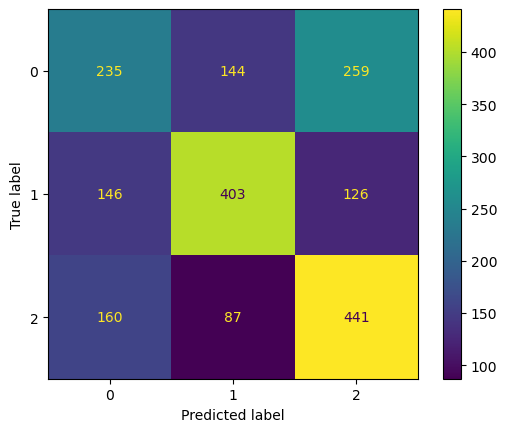

In [139]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)

In [140]:
print(f'The current best accuracy with XG Boost is : {round(best_xgb_model.score(X_test, y_test),3)}')

The current best accuracy with XG Boost is : 0.539
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.417 total time=   0.5s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.401 total time=   0.5s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.507 total time=   0.7s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.520 total time=   1.2s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), mode

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=RobustScaler();, score=0.518 total time= 1.4min
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=100, scaler=StandardScaler();, score=0.505 total time= 2.1min
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=100, scaler=RobustScaler();, score=0.498 total time= 3.5min
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10000, scaler=MinMaxScaler();, score=0.509 total time=  14.1s
[C

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=RobustScaler();, score=0.498 total time=  31.1s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=MinMaxScaler();, score=0.474 total time=   5.0s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=RobustScaler();, score=0.501 total time= 2.6min
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=MinMaxScaler();, score=0.456 total time=   1.4s
[CV 1/5] EN

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  14.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  14.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  20.8s
[CV] END max_depth=20, max_features=log

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10000, scaler=MinMaxScaler();, score=0.500 total time=  10.0s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10000, scaler=RobustScaler();, score=0.498 total time= 3.7min
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=100, scaler=MinMaxScaler();, score=0.496 total time= 2.0min
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1000, scaler=MinMaxScaler();, score=0.482 total time=   4.0s
[

[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.001, scaler=MinMaxScaler();, score=0.415 total time=   0.5s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.001, scaler=RobustScaler();, score=0.506 total time=   0.7s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.01, scaler=StandardScaler();, score=0.504 total time=   1.3s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.450 total time=   0.9s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1), model__C=0.01, scaler=MinMaxScaler();, score=0.462 total

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  43.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.2min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  14.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  15.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  14.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  42.6s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  33.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   6.6s
[CV] END max_depth=20, max_features

[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1e-05, scaler=RobustScaler();, score=0.348 total time=  15.1s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=RobustScaler();, score=0.348 total time=   1.4s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.001, scaler=RobustScaler();, score=0.362 total time=   2.5s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.01, scaler=RobustScaler();, score=0.476 total time=   3

[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.1, scaler=StandardScaler();, score=0.512 total time=   8.1s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.1, scaler=MinMaxScaler();, score=0.465 total time=   2.9s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.1, scaler=RobustScaler();, score=0.505 total time=   8.4s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=StandardScaler();, score=0.511 total time= 1.4min
[CV 5/

[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  20.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  19.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  19.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  19.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  19.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  33.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   7.2s
[CV] END max_depth=20, max_features=l

[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=StandardScaler();, score=0.511 total time= 3.3min
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=100, scaler=MinMaxScaler();, score=0.498 total time= 2.5min
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1000, scaler=RobustScaler();, score=0.512 total time= 3.0min
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=MinMaxScaler();, score=0.492 total time=   3.5s
[CV 3

[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  19.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  20.2s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=StandardScaler();, score=0.348 total time=   8.3s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=StandardScaler();, score=0.348 total time=   6.5s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=RobustScaler();, score=0.348 total time=   1.3s

[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=MinMaxScaler();, score=0.496 total time=  21.8s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=MinMaxScaler();, score=0.500 total time=  19.9s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=MinMaxScaler();, score=0.499 total time=  21.8s
[CV 2/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=100, scaler=StandardScaler();, score=0.496 total time= 3.5min
[CV 2

[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=MinMaxScaler();, score=0.488 total time=   2.9s
[CV 3/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=MinMaxScaler();, score=0.500 total time=   3.1s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=RobustScaler();, score=0.518 total time=  57.0s
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.9, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=MinMaxScaler();, score=0.495 total time=  12.5s
[CV 3/5] END di

[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1, scaler=RobustScaler();, score=0.510 total time= 1.4min
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10, scaler=RobustScaler();, score=0.502 total time= 3.4min
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1000, scaler=StandardScaler();, score=0.505 total time= 2.6min
[CV 1/5] END dim_reducer=PCA(), dim_reducer__n_components=0.95, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10000, scaler=RobustScaler();, score=0.502 total time= 2.8min
[C

[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.85, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=10000, scaler=StandardScaler();, score=0.512 total time=  19.6s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=1e-05, scaler=RobustScaler();, score=0.348 total time=   2.5s
[CV 5/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=StandardScaler();, score=0.348 total time=   0.8s
[CV 4/5] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', random_state=1,
                   solver='saga'), model__C=0.0001, scaler=RobustScaler();, score=0.348 total time= 

## The models are just a first draft of what it can do, I haven't optimized a lot yet.

## More to follow